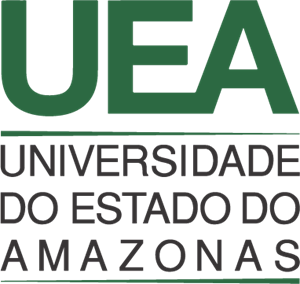

- Módulo: Ciência de Dados para Negócios

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import resample

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

import pickle

Install Extra Libraries

In [2]:
# install
!pip install shap
!pip install xgboost
!pip install catboost
!pip install lightgbm

import xgboost
import catboost
import lightgbm as lgb

     |████████████████████████████████| 564 kB 5.1 MB/s 
     |████████████████████████████████| 76.3 MB 1.2 MB/s 


##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [3]:
!pip install kaggle

###Get Files

In [5]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/homesite-quote-conversion
  !kaggle competitions download -c homesite-quote-conversion --force
  !unzip ./test.csv.zip
  !unzip ./train.csv.zip
  !unzip ./sample_submission.csv.zip
  !ls -la ./

In [6]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [7]:
get_data_from_competition()

  0% 0.00/258k [00:00<?, ?B/s]
100% 258k/258k [00:00<00:00, 40.0MB/s]
 69% 17.0M/24.7M [00:00<00:00, 61.7MB/s]
100% 24.7M/24.7M [00:00<00:00, 70.8MB/s]
 78% 29.0M/37.1M [00:00<00:00, 66.6MB/s]
100% 37.1M/37.1M [00:00<00:00, 107MB/s] 
Archive:  ./test.csv.zip
  inflating: test.csv                
Archive:  ./train.csv.zip
  inflating: train.csv               
Archive:  ./sample_submission.csv.zip
  inflating: sample_submission.csv   
total 402160
drwxr-xr-x 1 root root      4096 Dec 15 01:02 .
drwxr-xr-x 1 root root      4096 Dec 15 00:45 ..
drwxr-xr-x 4 root root      4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root      4096 Dec  3 14:33 sample_data
-rw-r--r-- 1 root root   1520192 Nov  4  2015 sample_submission.csv
-rw-r--r-- 1 root root    264355 Dec 15 01:02 sample_submission.csv.zip
-rw-r--r-- 1 root root 137849053 Nov  4  2015 test.csv
-rw-r--r-- 1 root root  25927745 Dec 15 01:02 test.csv.zip
-rw-r--r-- 1 root root 207278432 Nov  4  2015 train.csv
-rw-r--r-- 1 root root  3893918

###Initial view

In [9]:
df_dados_teste = pd.read_csv('./test.csv')
df_dados_treino = pd.read_csv('./train.csv')
df_template_sub = pd.read_csv('./sample_submission.csv')

#Utils

In [36]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

def plot_target_distribution(df_aux):
  print(df_aux['QuoteConversion_Flag'].value_counts())
  plt.figure(figsize = (6,4))
  plt.margins(.2)
  ax = sns.countplot(x = 'QuoteConversion_Flag', 
                    data = df_aux)
  x_labels = ['Não', 'Sim']
  ax.set_xticklabels(x_labels)
  ax.set_title('Cotações de seguro de Casa')
  ax.set_xlabel('Cotações')
  ax.set_ylabel('Qtd. de cotações')
  # plt.xticks(rotation=45)
  add_value_labels(ax)
  plt.show() 

def add_value_labels(ax, spacing=5):
    # reference: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        label = "{:1.1f}K".format(y_value*0.001)
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

def fill_na_values(df, value):
  return df.fillna(value)

def split_data_for_xy_columns(df, col_begin, col_end, target):
  split_X = df.loc[:,col_begin:col_end]
  split_y = df.loc[:,target]
  return split_X, split_y 

# Reference: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# Feature Importance
def get_columns_by_importance(X, y, number_col):
  model = ExtraTreesClassifier()
  model.fit(X,y)
  #use inbuilt class feature_importances of tree based classifiers
  # print(model.feature_importances_)
  #plot graph of feature importances for better visualization
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  columns = feat_importances.nlargest(number_col)
  columns.plot(kind='barh')
  plt.show()
  return columns.index

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            shuffle = True,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')


def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)
  
def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  print('### Fit model ###')
  model.fit(X_tr, y_tr)
  print('### Result: ###')
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def plot_correlation_matrix(df):
  fig, ax = plt.subplots(figsize=(14,14))
  corr = df.corr()
  plot = sns.heatmap(corr, annot = True, fmt=".1f", linewidths=.6, ax=ax)
  plot

def save_model(model):
  # save the model to disk
  filename = 'model.pkl'
  pickle.dump(model, open(filename, 'wb'))


Dados de Treino

In [11]:
df_dados_treino.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField4A,PersonalField4B,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField10A,PersonalField10B,PersonalField11,PersonalField12,PersonalField13,PersonalField14,PersonalField15,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2A,PropertyField2B,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField16A,PropertyField16B,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField21A,PropertyField21B,PropertyField22,PropertyField23,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField27,PropertyField28,PropertyField29,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField5A,GeographicField5B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField10A,GeographicField10B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField14A,GeographicField14B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18A,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21A,GeographicField21B,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,GeographicField33A,GeographicField33B,GeographicField34A,GeographicField34B,GeographicField35A,GeographicField35B,GeographicField36A,GeographicFie

0    211859
1     48894
Name: QuoteConversion_Flag, dtype: int64


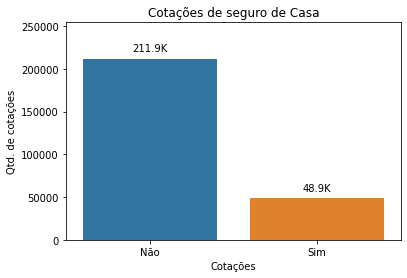

In [12]:
plot_target_distribution(df_dados_treino)

## Aumentando Classe **Minoritária**

Escoha a quantidade de pacientes diabéticos para treinamento dos modelos

In [14]:
#@title Quantidade Cotações realizadas: SIM
max_num_diabetes =  80000#@param {type:"integer"}

# ref: https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = df_dados_treino[df_dados_treino['QuoteConversion_Flag'] == 0]
df_minority = df_dados_treino[df_dados_treino['QuoteConversion_Flag'] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=max_num_diabetes,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
print(df_upsampled['QuoteConversion_Flag'].value_counts())
df_dados_treino = df_upsampled

0    211859
1     80000
Name: QuoteConversion_Flag, dtype: int64


0    211859
1     80000
Name: QuoteConversion_Flag, dtype: int64


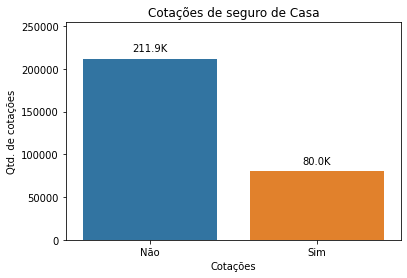

In [16]:
plot_target_distribution(df_dados_treino)

##Remove columns

In [15]:
rm_columns = [ 'Original_Quote_Date' ]

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

##ETL

In [17]:
explore_dataset(df_dados_treino)

(291859, 298)
--------------------
       QuoteNumber  QuoteConversion_Flag     Field7     Field8    Field9  \
count    291859.00             291859.00  291859.00  291859.00  291859.0   
mean     217238.95                  0.27      18.07       0.94       0.0   
std      125544.21                  0.45       7.46       0.04       0.0   
min           1.00                  0.00       1.00       0.87       0.0   
25%      108502.50                  0.00      11.00       0.92       0.0   
50%      217047.00                  0.00      23.00       0.94       0.0   
75%      326123.00                  1.00      24.00       0.97       0.0   
max      434588.00                  1.00      28.00       1.01       0.0   

         Field11  CoverageField1A  CoverageField1B  CoverageField2A  \
count  291859.00        291859.00        291859.00        291859.00   
mean        1.16             8.91            12.88             8.96   
std         0.12             5.51             7.19             5.50

In [18]:
fields_to_tranform = [
                      'Field6',
                      'Field10',
                      'Field12',
                      'CoverageField8',
                      'CoverageField9',
                      'SalesField7',
                      'PersonalField7',
                      'PersonalField16',
                      'PersonalField17',
                      'PersonalField18',
                      'PersonalField19',
                      'PropertyField3',
                      'PropertyField4',
                      'PropertyField5',
                      'PropertyField7',
                      'PropertyField14',
                      'PropertyField28',
                      'PropertyField30',
                      'PropertyField31',
                      'PropertyField32',
                      'PropertyField33',
                      'PropertyField34',
                      'PropertyField36',
                      'PropertyField37',
                      'PropertyField38',
                      'GeographicField63',
                      'GeographicField64'
                      ]
                      
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

In [19]:
# fill na with median
df_dados_treino = fill_na_values(df_dados_treino, df_dados_treino.median())
df_dados_teste = fill_na_values(df_dados_teste, df_dados_teste.median())

In [20]:
#Check fields in dataset before run
X, y = split_data_for_xy_columns(df_dados_treino,'Field6', 'GeographicField64', target='QuoteConversion_Flag')

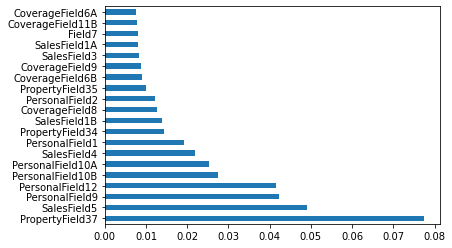

In [21]:
columns_important = get_columns_by_importance(X, y, 20)

In [22]:
list_aux = columns_important.values.tolist()
list_aux.insert(0,'QuoteNumber')
print(len(list_aux))

df_dados_teste = df_dados_teste.loc[:, df_dados_teste.columns.isin(list_aux)]

list_aux.insert(len(list_aux), 'QuoteConversion_Flag')
print(len(list_aux))
df_dados_treino = df_dados_treino.loc[:, df_dados_treino.columns.isin(list_aux)]
print(df_dados_treino.shape) 

21
22
(291859, 22)


In [23]:
df_dados_treino.head()

,QuoteNumber,QuoteConversion_Flag,Field7,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11B,SalesField1A,SalesField1B,SalesField3,SalesField4,SalesField5,PersonalField1,PersonalField2,PersonalField9,PersonalField10A,PersonalField10B,PersonalField12,PropertyField34,PropertyField35,PropertyField37
83369,138902,1,16,13,23,5,10,22,3,8,1,5,4,1,1,2,6,12,1,1,2,1
148858,247789,1,11,13,23,0,4,2,2,4,1,5,3,1,1,2,7,15,1,1,1,0
94291,157090,1,24,13,23,0,3,17,2,3,0,5,5,1,1,2,6,13,1,1,2,0
81591,135931,1,11,1,6,5,4,21,2,4,1,4,3,0,0,2,5,5,2,1,2,1
41475,68871,1,25,25,25,5,4,10,3,9,1,3,4,1,1,2,5,7,1,0,2,1


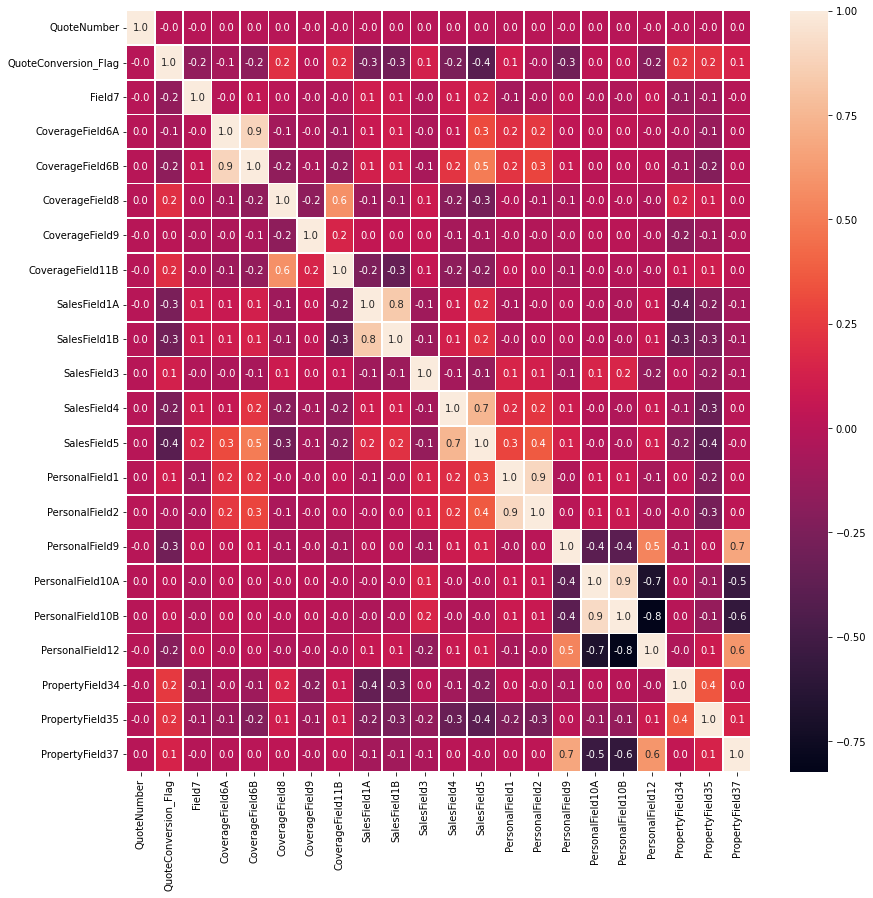

In [37]:
plot_correlation_matrix(df_dados_treino)

#Machine Learning Algorithms

In [24]:
X, y = split_data_for_xy_columns(df_dados_treino,'CoverageField6B', 'PropertyField37', target='QuoteConversion_Flag')
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.30, random=1)

Amostras de treino:
 * X_train: (204301, 18)
 * y_train: (204301,)
Amostras de teste:
 * X_test: (87558, 18)
 * y_test: (87558,)


##XGBoost

In [25]:
work_metric = "roc_auc"

xgb_model = xgboost.XGBClassifier(booster = 'gbtree', 
                                  learning_rate = 0.005,
                                  n_estimators = 100,
                                  max_depth = 15,
                                  random_state = 0)


print('****************** XGBoost ******************')
xgb_model = create_cross_validation_model(xgb_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** XGBoost ******************
Cross Validation Result

roc_auc: [0.95171895 0.95220672 0.94965828 0.95067303 0.95229872]

roc_auc (média): 0.9513
roc_auc (desvio padrão): 0.001


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.9
              precision    recall  f1-score   support

          NO       0.91      0.95      0.93     63558
         YES       0.86      0.74      0.80     24000

    accuracy                           0.90     87558
   macro avg       0.88      0.85      0.86     87558
weighted avg       0.89      0.90      0.89     87558



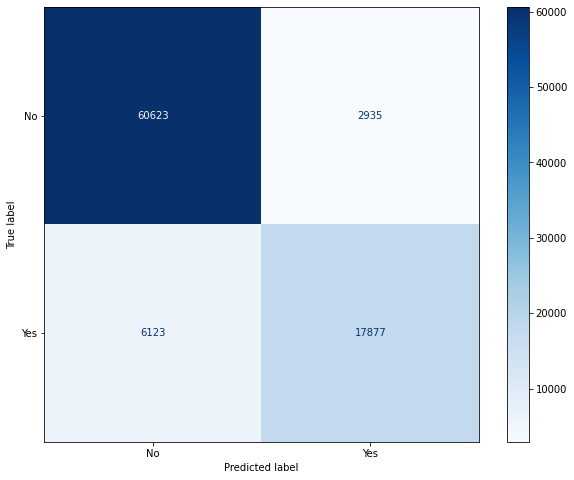

In [26]:
xgb_model = validate_ens_model(xgb_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

In [132]:
save_model(xgb_model)

## Random Forest

In [42]:
def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

In [43]:
ens_random_forest_model = create_ens_random_forest(16, 100)
print('****************** Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** Random Forest ******************
Cross Validation Result

roc_auc: [0.95880154 0.9591058  0.9575645  0.95873707 0.95934639]

roc_auc (média): 0.9587
roc_auc (desvio padrão): 0.0006


### Fit model ###
### Result: ###
Acurácia (Treino): 0.91
Acurácia (Teste): 0.9
              precision    recall  f1-score   support

          NO       0.91      0.96      0.93     63558
         YES       0.87      0.75      0.81     24000

    accuracy                           0.90     87558
   macro avg       0.89      0.86      0.87     87558
weighted avg       0.90      0.90      0.90     87558



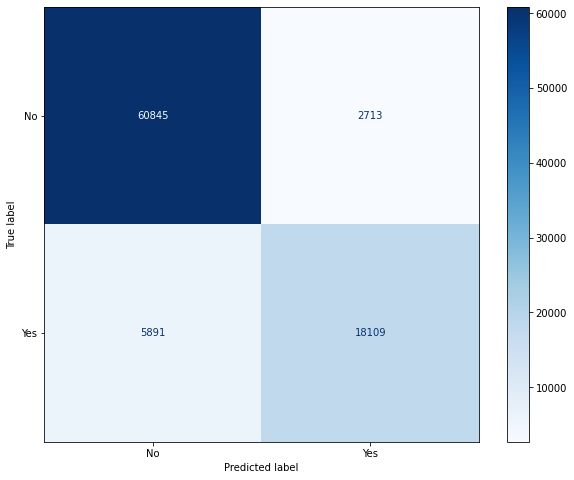

In [44]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

## CatBoost

In [45]:
 cat_boost_model = catboost.CatBoostClassifier(iterations=5,
                         learning_rate=0.025,
                         depth=15,
                         random_state=0)

In [46]:
print('****************** CatBoost ******************')
cat_boost_model = create_cross_validation_model(cat_boost_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** CatBoost ******************
0:	learn: 0.6769077	total: 307ms	remaining: 1.23s
1:	learn: 0.6616454	total: 582ms	remaining: 872ms
2:	learn: 0.6468419	total: 756ms	remaining: 504ms
3:	learn: 0.6327830	total: 882ms	remaining: 220ms
4:	learn: 0.6191043	total: 965ms	remaining: 0us
0:	learn: 0.6769282	total: 175ms	remaining: 699ms
1:	learn: 0.6616833	total: 354ms	remaining: 530ms
2:	learn: 0.6468849	total: 540ms	remaining: 360ms
3:	learn: 0.6328395	total: 660ms	remaining: 165ms
4:	learn: 0.6191790	total: 739ms	remaining: 0us
0:	learn: 0.6768788	total: 161ms	remaining: 645ms
1:	learn: 0.6616711	total: 341ms	remaining: 511ms
2:	learn: 0.6468588	total: 524ms	remaining: 349ms
3:	learn: 0.6327938	total: 638ms	remaining: 160ms
4:	learn: 0.6191252	total: 718ms	remaining: 0us
0:	learn: 0.6770365	total: 157ms	remaining: 629ms
1:	learn: 0.6617855	total: 327ms	remaining: 490ms
2:	learn: 0.6469997	total: 507ms	remaining: 338ms
3:	learn: 0.6329441	total: 618ms	remaining: 154ms
4:	learn:

### Fit model ###
0:	learn: 0.6770445	total: 222ms	remaining: 887ms
1:	learn: 0.6613019	total: 285ms	remaining: 427ms
2:	learn: 0.6462789	total: 390ms	remaining: 260ms
3:	learn: 0.6321196	total: 498ms	remaining: 125ms
4:	learn: 0.6185446	total: 690ms	remaining: 0us
### Result: ###
Acurácia (Treino): 0.89
Acurácia (Teste): 0.89
              precision    recall  f1-score   support

          NO       0.89      0.96      0.93     63558
         YES       0.87      0.70      0.78     24000

    accuracy                           0.89     87558
   macro avg       0.88      0.83      0.85     87558
weighted avg       0.89      0.89      0.89     87558



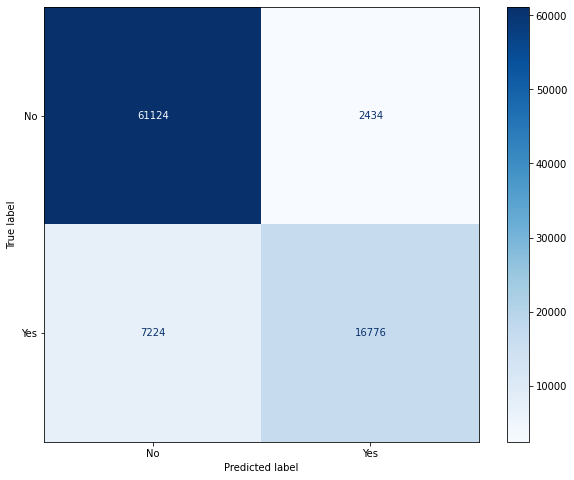

In [47]:
cat_boost_model = validate_ens_model(cat_boost_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)